In [1]:
import os
from keys import OPENAI_API_KEY, GOOGLE_API_KEY, GOOGLE_CSE_ID
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["GOOGLE_CSE_ID"] = GOOGLE_CSE_ID

## Recreating Bing Chatbot

### Flow Diagram

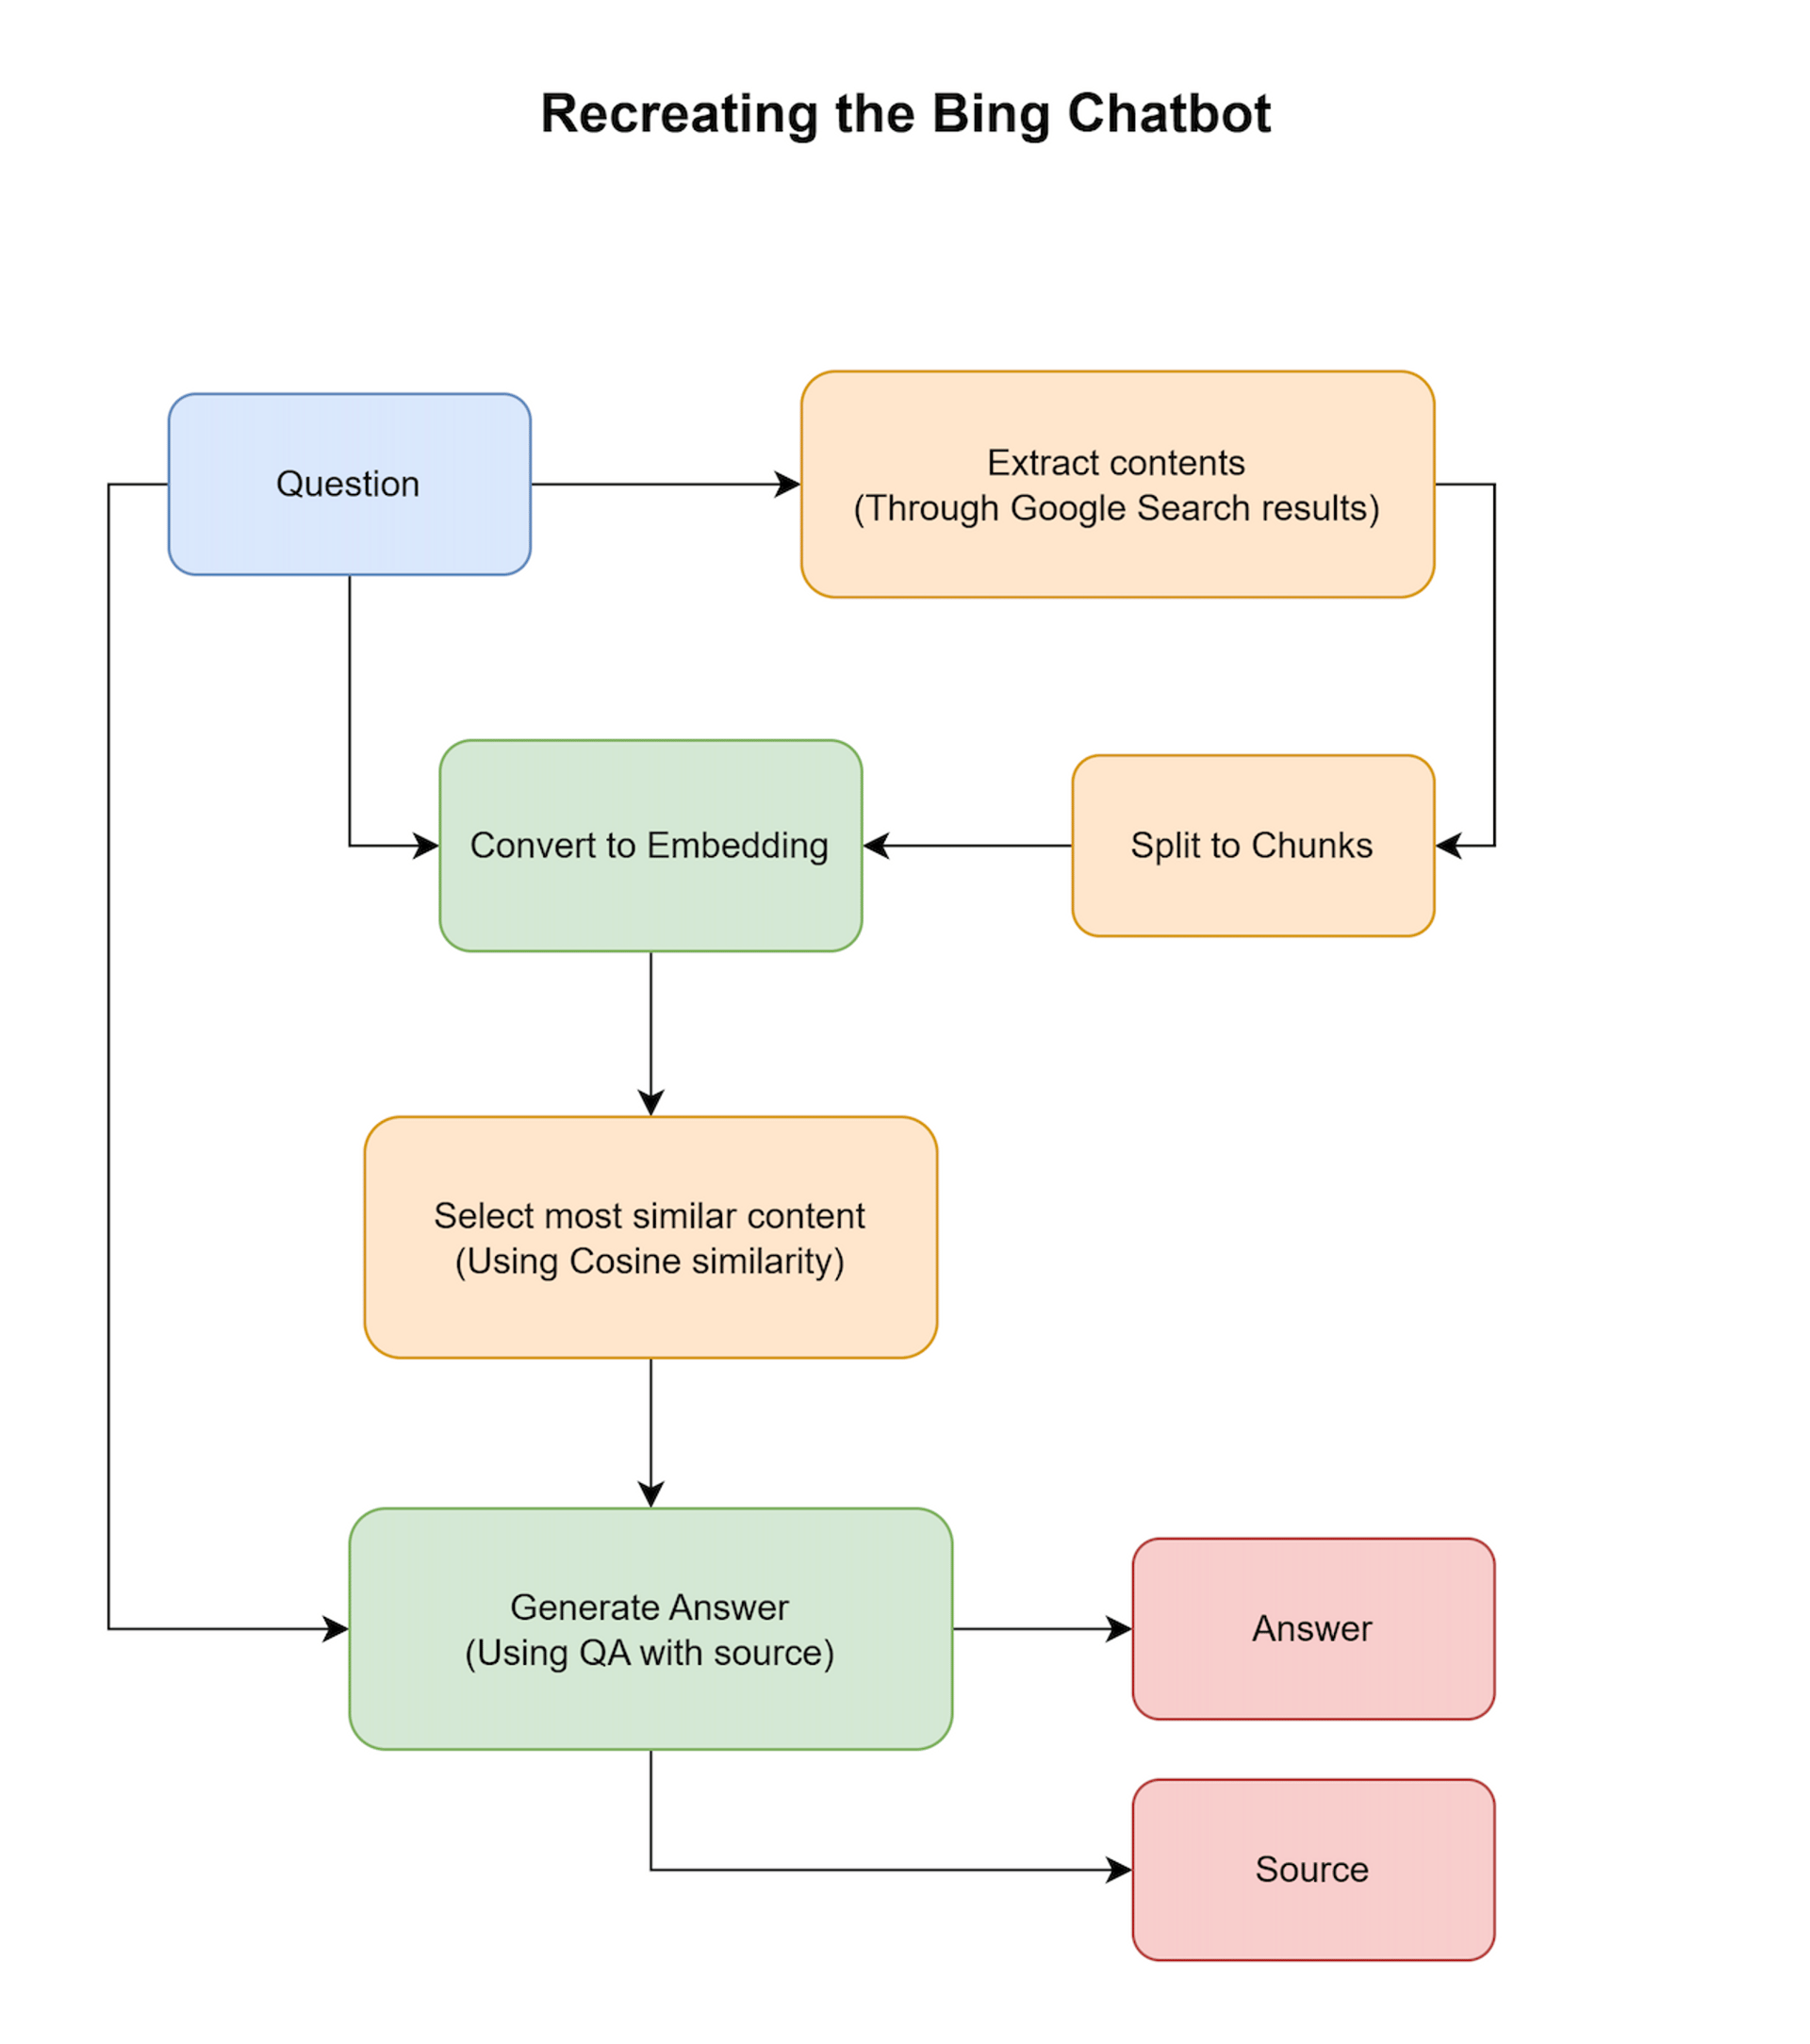

In [1]:
from PIL import Image
from io import BytesIO
from IPython.display import display
import requests

img_url = 'https://images.spr.so/cdn-cgi/imagedelivery/j42No7y-dcokJuNgXeA0ig/43d1b24a-4834-4820-91f5-077c0b1e626e/Screenshot_2023-06-09_at_13.39.38/w=1920,quality=80'
res = requests.get(img_url, stream=True)
img = Image.open(BytesIO(res.content))
display(img)

In [4]:
from langchain import LLMChain, PromptTemplate
from langchain.llms import OpenAI

llm = OpenAI(temperature=0)

template = """You are an assistant that answers the following question correctly and honestly: {question}\n\n"""
prompt_template = PromptTemplate(input_variables=["question"], template=template)

question_chain = LLMChain(llm=llm, prompt=prompt_template)

question_chain.run("what is the latest fast and furious movie?")

'\nThe latest Fast and Furious movie is Fast & Furious 9, which was released in May 2021.'

In [13]:
from langchain.tools import Tool
from langchain.utilities import GoogleSearchAPIWrapper

search = GoogleSearchAPIWrapper()
TOP_N_RESULTS = 10

def top_n_results(query):
    return search.results(query, TOP_N_RESULTS)

tool = Tool(
    name = "Google Search",
    description="Search Google for recent results.",
    func=top_n_results
)

query = "What is the latest fast and furious movie?"

results = tool.run(query)

for result in results:
    print(result["title"])
    print(result["link"])
    print(result["snippet"])
    print("-"*50)

Fast & Furious movies in order | chronological and release order ...
https://www.radiotimes.com/movies/fast-and-furious-order/
Mar 22, 2023 ... Fast & Furious Presents: Hobbs & Shaw (2019); F9 (2021); Fast and Furious 10 (2023). Tokyo Drift also marks the first appearance of Han Lue, a ...
--------------------------------------------------
FAST X | Official Trailer 2 - YouTube
https://www.youtube.com/watch?v=aOb15GVFZxU
Apr 19, 2023 ... FAST X | Official Trailer 2 · Comments10K.
--------------------------------------------------
How to Watch Fast and Furious Movies in Chronological Order - IGN
https://www.ign.com/articles/fast-and-furious-movies-in-order
This is the last Fast film with Paul Walker's Brian O'Conner, as Walker died during the time of its filming. Furious 7 ends with an emotional farewell to Brian/ ...
--------------------------------------------------
Fast & Furious - Wikipedia
https://en.wikipedia.org/wiki/Fast_%26_Furious
It began the original tetralogy of films focuse

In [14]:
import newspaper

pages_content = []

for result in results:
	try:
		article = newspaper.Article(result["link"])
		article.download()
		article.parse()
		if len(article.text) > 0:
			pages_content.append({ "url": result["link"], "text": article.text })
	except:
		continue

In [15]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document

text_splitter = RecursiveCharacterTextSplitter(chunk_size=4000, chunk_overlap=100)

docs = []
for d in pages_content:
	chunks = text_splitter.split_text(d["text"])
	for chunk in chunks:
		new_doc = Document(page_content=chunk, metadata={ "source": d["url"] })
		docs.append(new_doc)

In [16]:
from langchain.embeddings import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

docs_embeddings = embeddings.embed_documents([doc.page_content for doc in docs])
query_embedding = embeddings.embed_query(query)

In [17]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_top_k_indices(list_of_doc_vectors, query_vector, top_k):
  # convert the lists of vectors to numpy arrays
  list_of_doc_vectors = np.array(list_of_doc_vectors)
  query_vector = np.array(query_vector)

  # compute cosine similarities
  similarities = cosine_similarity(query_vector.reshape(1, -1), list_of_doc_vectors).flatten()

  # sort the vectors based on cosine similarity
  sorted_indices = np.argsort(similarities)[::-1]

  # retrieve the top K indices from the sorted list
  top_k_indices = sorted_indices[:top_k]

  return top_k_indices

top_k = 2
best_indexes = get_top_k_indices(docs_embeddings, query_embedding, top_k)
best_k_documents = [doc for i, doc in enumerate(docs) if i in best_indexes]

In [18]:
from langchain.chains.qa_with_sources import load_qa_with_sources_chain
from langchain.llms import OpenAI

chain = load_qa_with_sources_chain(OpenAI(temperature=0), chain_type="stuff")

response = chain({"input_documents": best_k_documents, "question": query}, return_only_outputs=True)

response_text, response_sources = response["output_text"].split("SOURCES:")
response_text = response_text.strip()
response_sources = response_sources.strip()

print(f"Answer: {response_text}")
print(f"Sources: {response_sources}")

Answer: The latest Fast and Furious movie is Fast and Furious Presents: Hobbs & Shaw (2019).
Sources: https://en.wikipedia.org/wiki/Fast_%26_Furious, https://www.menshealth.com/entertainment/a36716650/fast-and-furious-movies-in-order/


## Web-Based Question Answering

In [2]:
from langchain.llms import OpenAI
from langchain.agents import Tool, initialize_agent, AgentType

from langchain.utilities import GoogleSearchAPIWrapper, PythonREPL

In [3]:
search = GoogleSearchAPIWrapper()
python_repl = PythonREPL()

In [4]:
llm = OpenAI(model="text-davinci-003", temperature=0)

In [5]:
toolkit = [
    Tool(
        name="google-search",
        func=search.run,
        description="useful for when you need to search Google to answer questions about current events"
    ),
    Tool(
        name="python_repl",
        description="A Python shell. Use this to execute Python commands. Input should be a valid Python command. Useful for saving strings to files.",
        func=python_repl.run
    )
]

In [7]:
agent = initialize_agent(
	toolkit,
	llm,
	agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
	verbose=True
)

In [9]:
agent.run("Find the birth date of Napoleon Bonaparte and save it to a file 'final.txt'.")



> Entering new AgentExecutor chain...
 I need to search for the birth date of Napoleon Bonaparte.
Action: google-search
Action Input: "Napoleon Bonaparte birth date"
Observation: Napoleon Bonaparte (born Napoleone Buonaparte; 15 August 1769 – 5 May 1821), later known by his regnal name Napoleon I, was a French military commander and ... Nov 9, 2009 ... Napoleon Bonaparte was born on August 15, 1769, in Ajaccio, on the Mediterranean island of Corsica. He was the second of eight surviving ... Napoleone Buonaparte was born in Ajaccio, Corsica, on 15 August 1769. He was the second of eight children born to Carlo Buonaparte, a lawyer descended from ... 6 days ago ... Napoleon Bonaparte was born on August 15, 1769. He was most notably known as a French military and political leader, who became prominent ... Aug 11, 2023 ... Napoleon was born on Corsica shortly after the island's cession to France by the Genoese. He was the fourth, and second surviving, child of ... In 1764, Charles-Marie B

'Napoleon Bonaparte was born on August 15, 1769.'

In [10]:
query = "Find when Napoleon Bonaparte died and append this information " \
    "to the content of the 'final.txt' file in a new line."

agent.run(query)



> Entering new AgentExecutor chain...
 I need to find the date of Napoleon's death and then save it to a file.
Action: google-search
Action Input: "when did Napoleon Bonaparte die"
Observation: The British exiled him to the remote island of Saint Helena in the Atlantic, where he died in 1821 at the age of 51. Napoleon had an extensive impact on the ... Aug 15, 2022 ... Napoleon was only 51 when he died on the island of St. Helena, where he was out of power and exiled from his beloved France. By May 5, 1821, ... Nov 9, 2009 ... In October 1815, Napoleon was exiled to the remote, British-held island of Saint Helena, in the South Atlantic Ocean. He died there on May 5, ... Apr 25, 2014 ... Napoleon Bonaparte died at 5.49pm on 5 May 1821, at Longwood on the island of Saint Helena. An autopsy was carried out on 6 May; ... Mar 3, 2010 ... Napoleon Bonaparte, the former French ruler who once ruled an empire that stretched across Europe, dies as a British prisoner on the remote ... Jan 17, 2

'Napoleon Bonaparte died on May 5, 1821.'

#### Review Contents of File

In [12]:
with open('final.txt', 'r') as f:
    contents = f.read()

contents

'August 15, 1769Napoleon Bonaparte died on May 5, 1821.'